# File Overview

This file analyses the "choose all that apply" technology answers, looking for outliers by country.

* These answers are stored as ';' delimited lists of answers for each respondent. Some processing is required to get the data in a usable format.
* Then we compute some statistics per country, per answer, and per question, then draw conclusions

# Outputs / Assets

* largest_outliers by deviation table
* Microsoft product interest by country grouped bar chart

In [1]:
country_min_sample_cutoff = 1000

In [2]:
import pandas as pd
import time

pd.options.display.max_rows = 2000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = 255

df = pd.read_csv('./assets/survey_results_public.csv')
schema = pd.read_csv('./assets/survey_results_schema.csv')
multiple_choice_technology_columns = [
    'DatabaseDesireNextYear',
    'DatabaseWorkedWith',
    'LanguageDesireNextYear',
    'LanguageWorkedWith',
    'MiscTechDesireNextYear',
    'MiscTechWorkedWith',
    'NEWCollabToolsDesireNextYear',
    'NEWCollabToolsWorkedWith',
    'PlatformDesireNextYear',
    'PlatformWorkedWith',
    'WebframeDesireNextYear',
    'WebframeWorkedWith'
]

# Data Preparation

### Only use responses from one of the 13 countries with a "large" response volume

In [3]:
countries = df['Country'].value_counts()
countries_with_enough_samples = countries[countries > (country_min_sample_cutoff)].index.values
country_subset = df.query('Country in @countries_with_enough_samples')

### Parse the multi response answer format

The `compute_multiple_choice_response_stats` processes the survey responses and produces 4 data frames:

* question_counts -> (question) -> question_response_count
* question_answer_counts -> (question, answer) -> answer_count
* question_counts_by_country -> (question, country) -> question_response_country_count
* answer_counts_by_country -> (question, answer, country) -> country_answer_count

With these data frames we perform a series of operations to identify which responses by country are most unusual

#### Data prep steps
* combine the data sets returned from `compute_multiple_choice_response_stats`
* compute the proportion of each answer across the full country set
* compute the proportion of each answer for each specific country
* compute the standard deviation per country for each (question,answer)
* for each (country, answer, question) : compute the deviations from the mean


In [4]:
from multiple_choice_responses.compute_multiple_choice_response_stats import compute_multiple_choice_response_stats
question_counts, question_answer_counts, question_counts_by_country, answer_counts_by_country = compute_multiple_choice_response_stats(country_subset, multiple_choice_technology_columns)

In [5]:
question_counts.head(2)

,question,question_response_count
0,DatabaseDesireNextYear,28455
1,DatabaseWorkedWith,32252


In [6]:
question_answer_counts.head(2)

,question,answer,answer_count,answer_proportion
0,DatabaseDesireNextYear,Cassandra,2762,0.097066
1,DatabaseDesireNextYear,Couchbase,1058,0.037182


In [7]:
question_counts_by_country.head(2)

,question,country,question_response_country_count
0,DatabaseDesireNextYear,Germany,2596
1,DatabaseWorkedWith,Germany,2986


In [8]:
answer_counts_by_country.head(2)

,question,country,answer,country_answer_count
0,DatabaseDesireNextYear,Germany,Microsoft SQL Server,400
1,DatabaseWorkedWith,Germany,Elasticsearch,504


In [9]:
combined_country_response_data = answer_counts_by_country \
  .merge(question_counts_by_country, on=['question', 'country'], how='left') \
  .merge(question_answer_counts, on=['question', 'answer'], how='left')

combined_country_response_data.head(2)

,question,country,answer,country_answer_count,question_response_country_count,answer_count,answer_proportion
0,DatabaseDesireNextYear,Germany,Microsoft SQL Server,400,2596,6244,0.219434
1,DatabaseWorkedWith,Germany,Elasticsearch,504,2986,4665,0.144642


In [10]:
combined_country_response_data['country_answer_proportion'] = \
    combined_country_response_data['country_answer_count'] / combined_country_response_data['question_response_country_count']

combined_country_response_data['country_answer_proportion_diff'] = \
    combined_country_response_data['country_answer_proportion'] - combined_country_response_data['answer_proportion']

question_answer_proportion_stddev = combined_country_response_data \
    .groupby(['question', 'answer']) \
    .std()['country_answer_proportion'] \
    .reset_index() \
    .rename(columns={ "country_answer_proportion": "answer_proportion_stddev" })

combined_country_response_data = combined_country_response_data \
    .merge(question_answer_proportion_stddev, on=['question', 'answer'], how='left')

combined_country_response_data['country_proportion_deviations_from_mean'] = \
    combined_country_response_data['country_answer_proportion_diff'] / combined_country_response_data['answer_proportion_stddev']
combined_country_response_data['country_proportion_abs_deviations_from_mean'] = \
    combined_country_response_data['country_proportion_deviations_from_mean'].abs()

combined_country_response_data.head(2)

,question,country,answer,country_answer_count,question_response_country_count,answer_count,answer_proportion,country_answer_proportion,country_answer_proportion_diff,answer_proportion_stddev,country_proportion_deviations_from_mean,country_proportion_abs_deviations_from_mean
0,DatabaseDesireNextYear,Germany,Microsoft SQL Server,400,2596,6244,0.219434,0.154083,-0.065351,0.043572,-1.499834,1.499834
1,DatabaseWorkedWith,Germany,Elasticsearch,504,2986,4665,0.144642,0.168788,0.024145,0.028586,0.844659,0.844659


# Data Analysis / Evaluation

* which answers are the most uncommon
* (based on analysis of previous) are there any sentiment trends regarding Microsoft technologies ?

In [11]:
largest_outliers = combined_country_response_data \
    .sort_values(by='country_proportion_abs_deviations_from_mean', ascending=False) \
    .rename(columns={ 'country_proportion_deviations_from_mean' : 'deviations from mean' }) \
    [['question', 'country', 'answer', 'deviations from mean']]

largest_outliers.head(10)

,question,country,answer,deviations from mean
2528,NEWCollabToolsDesireNextYear,Russian Federation,Microsoft Teams,-3.303201
1876,MiscTechWorkedWith,Italy,Xamarin,3.150133
757,WebframeWorkedWith,France,Symfony,3.148138
530,NEWCollabToolsDesireNextYear,Brazil,Trello,3.113455
1252,LanguageWorkedWith,Italy,Assembly,3.092435
533,NEWCollabToolsWorkedWith,Brazil,Trello,2.989476
1246,PlatformWorkedWith,Italy,Arduino,2.895572
876,WebframeDesireNextYear,France,Symfony,2.887714
1247,PlatformWorkedWith,Italy,Windows,2.885916
418,DatabaseDesireNextYear,France,Elasticsearch,2.873854


**Insight 1**

The top answer suggests respondents from Russia have a much lower interest in Microsoft technologies versus other countries in the result set.

Lets look at that in more detail by looking at answers that include "Microsoft" in them.

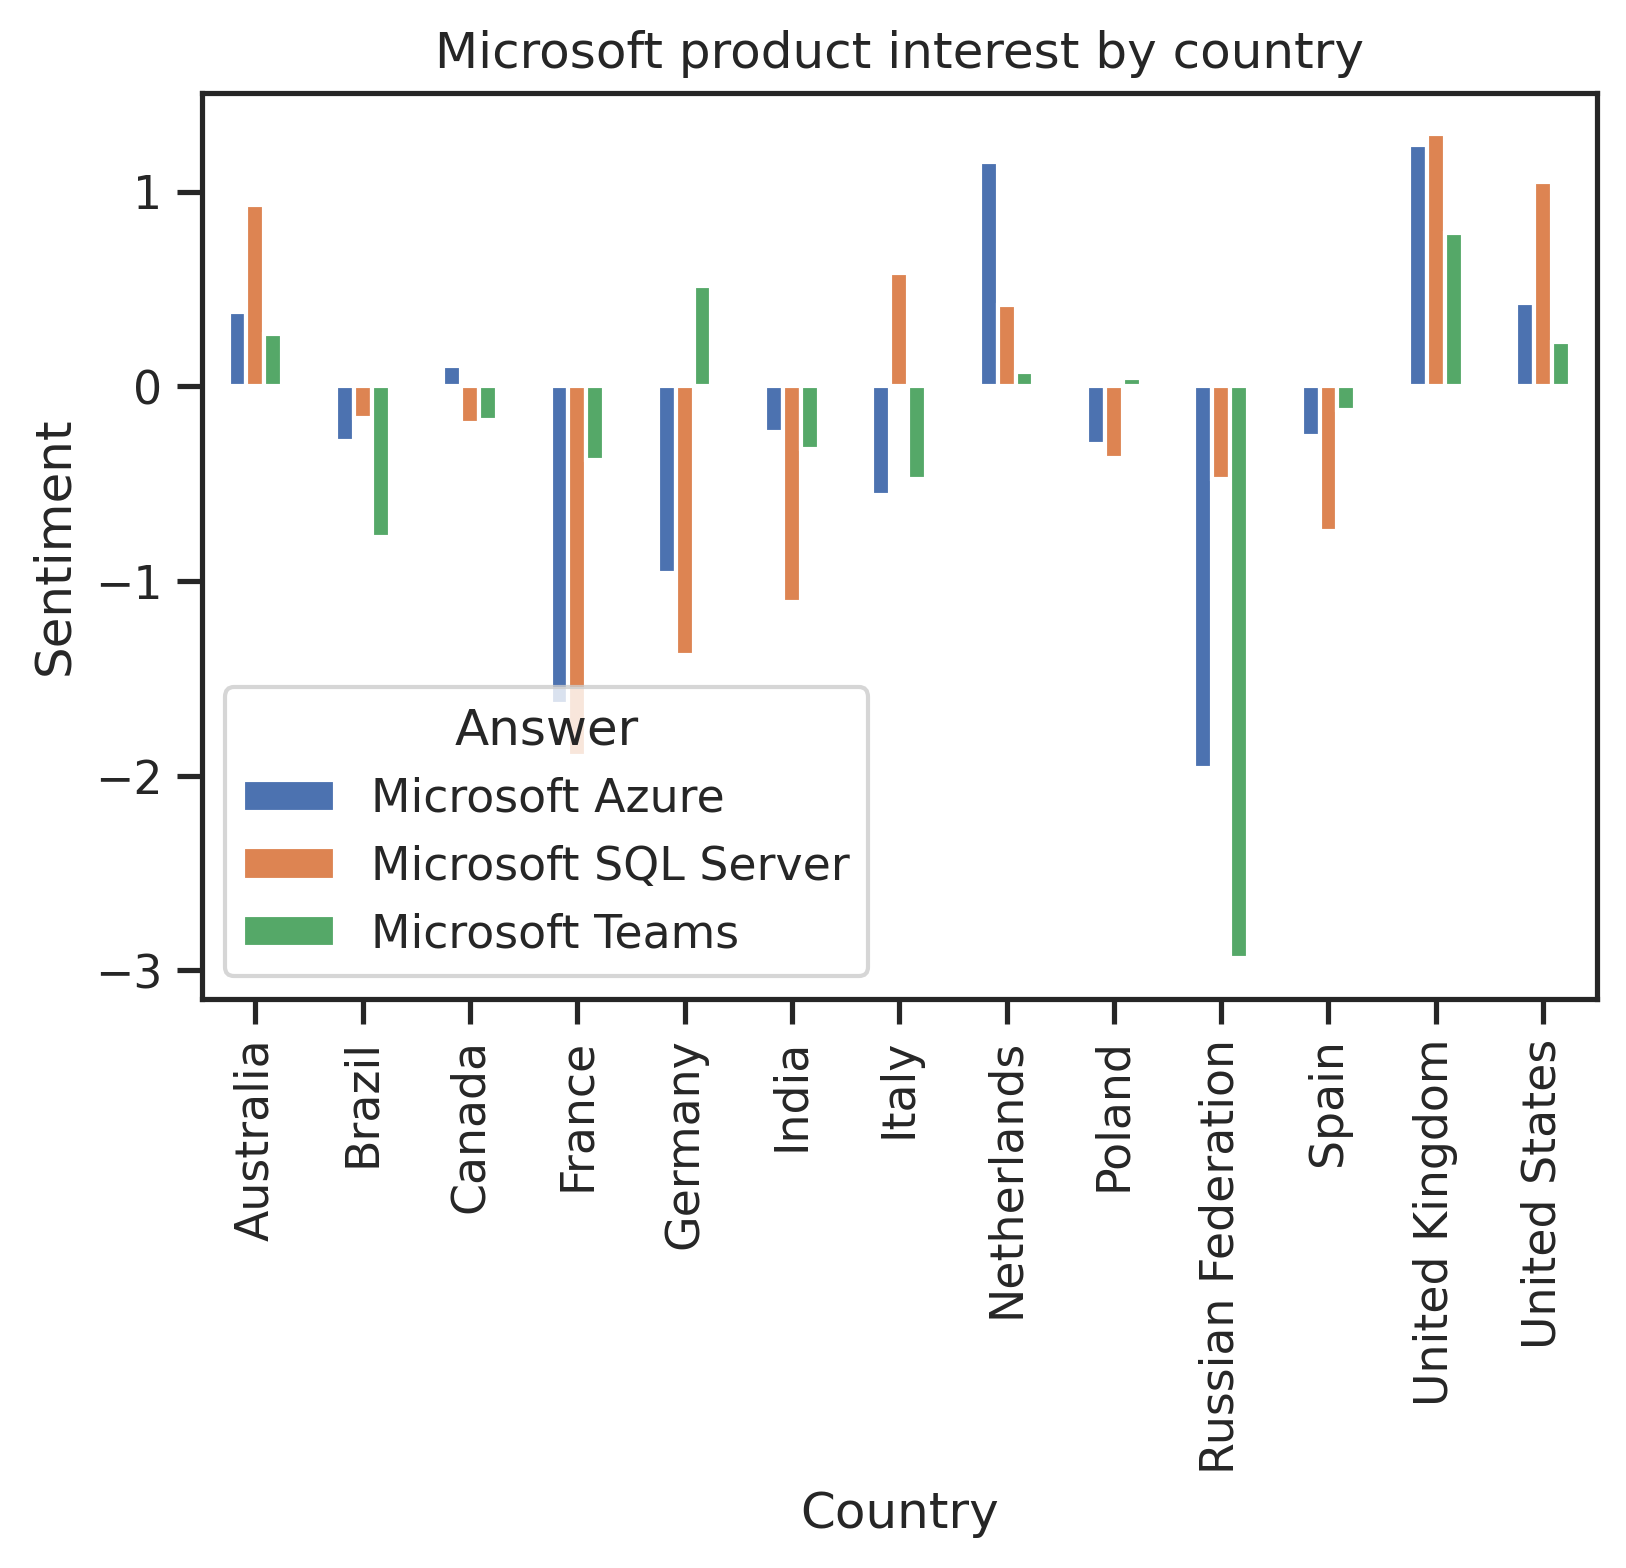

In [17]:
import seaborn as sns
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

microsoft_sentiment_outliers = combined_country_response_data \
    .sort_values(by=['country', 'question', 'answer']) \
    .query('answer.str.contains("Microsoft")', engine='python') \
    [['question', 'country', 'answer', 'country_proportion_deviations_from_mean']] \

# TODO it is not really correct to take the mean of the deviations. I am losing data here, as the volume of responses is lost.
# But the trend is probably not lost, and i suspect that after correctly processing data, I would end up with the same shape. So Im going to leave it as is for now

microsoft_sentiment_outliers_grouped_by_tech = microsoft_sentiment_outliers \
    .groupby(['country', 'answer']).mean() \
    .rename(columns={ "country_proportion_deviations_from_mean": "deviation_from_mean" })

microsoft_sentiment_outliers_grouped_by_tech \
    .reset_index() \
    .rename(columns={ "answer": "Answer", "country": "Country" }) \
    .pivot(index='Country', columns=['Answer'], values='deviation_from_mean') \
    .plot( \
          kind='bar', \
          title="Microsoft product interest by country", \
          ylabel="Sentiment"
    );

**Insight 2**

From the above we can see Australia, the United Kingdom, the Netherlands, and the United States have a greater than average interest in Microsoft technologies, whereas developers from Russia, Germany, France, and India are less interested.